# Ground Motion Fields Combination

#### Before starting
This project apply data porduced by Openquake to merge the two ground motion fields based on the volcanic attenuation.If you want to use these codes for other events/regions, you need to use OpenQuake to calculate two ground motion fields, each for the same source and sites but using different GMPEs. Export the CSV files containing the two ground motion fields into zip files and unzip it.  

The seismic event for this project is M 5.6 - 20 km ESE of Banjar, Indonesia. Information from https://earthquake.usgs.gov/earthquakes/eventpage/us6000j6k5/impact .

#### I. Import all the packages

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

#### II. Read and Preprocess Data

In [2]:
# Step 1: Read and Clean Site Coordinates Data

print("\nStep1.")

def clean_site_coords(file_path):
    data = pd.read_csv(file_path, skiprows=1)  # Skip the first row to get the correct column names
    data.columns = ['site_id', 'Longitude', 'Latitude']
    data['site_id'] = data['site_id'].astype(int)
    data['Longitude'] = data['Longitude'].astype(float)
    data['Latitude'] = data['Latitude'].astype(float)
    
#Test    
    assert not data.empty, "Site coordinates data should not be empty."
    assert 'site_id' in data.columns, "site_id column should exist."
    assert 'Longitude' in data.columns, "Longitude column should exist."
    assert 'Latitude' in data.columns, "Latitude column should exist."
    print("Site coordinates data cleaned:")
    print(data.head())
    
    return data

site_coords = clean_site_coords('assets/gmf_l_data-csv/sitemesh_16.csv')#The sitemesh files in "each ground motion field data folder" are the same.

# Step 2: Read and Process GMF Data

print("\nStep2.")

def process_gmf_data(file_path):
    data = pd.read_csv(file_path, skiprows=1)  # Skip the first row to get the correct column names
    data.columns = ['site_id', 'event_id', 'gmv_PGA']
    data['site_id'] = data['site_id'].astype(int)

#Test    
    assert not data.empty, f"GMF data from {file_path} should not be empty."
    assert 'site_id' in data.columns, "site_id column should exist."
    assert 'event_id' in data.columns, "event_id column should exist."
    assert 'gmv_PGA' in data.columns, "gmv_PGA column should exist."
    print(f"GMF data from {file_path} processed:")
    print(data.head())
    
    return data

gmf_h_data = process_gmf_data('assets/gmf_h_data-csv/gmf-data_15.csv')#The CSV file of high attenuation GMF
gmf_l_data = process_gmf_data('assets/gmf_l_data-csv/gmf-data_16.csv')#The CSV file of low attenuation GMF

# Step 3: Merge Site Coordinates with GMF Data

print("\nStep3.")

def merge_gmf_and_coords(gmf_data, site_coords):
    merged_data = gmf_data.merge(site_coords, on='site_id')
    
#Test
    assert not merged_data.empty, "Merged GMF data should not be empty."
    assert 'site_id' in merged_data.columns, "site_id column should exist in merged data."
    assert 'Longitude' in merged_data.columns, "Longitude column should exist in merged data."
    assert 'Latitude' in merged_data.columns, "Latitude column should exist in merged data."
    print("GMF data merged with site coordinates:")
    print(merged_data.head())
    
    return merged_data

gmf_h_data = merge_gmf_and_coords(gmf_h_data, site_coords)
gmf_l_data = merge_gmf_and_coords(gmf_l_data, site_coords)

# Step 4: Create GeoDataFrame

print("\nStep4.")

def create_geodataframe(gmf_data):
    gdf = gpd.GeoDataFrame(gmf_data, geometry=gpd.points_from_xy(gmf_data.Longitude, gmf_data.Latitude), crs="EPSG:4326")#CRS (Coordinate Reference System)
    
#Test
    assert not gdf.empty, "GeoDataFrame should not be empty."
    assert 'geometry' in gdf.columns, "GeoDataFrame should contain geometry column."
    assert gdf.crs.to_string() == 'EPSG:4326', "GeoDataFrame should have EPSG:4326 CRS."
    print("GeoDataFrame created:")
    print(gdf.head())
    
    return gdf

gmf_h_gdf = create_geodataframe(gmf_h_data)
gmf_l_gdf = create_geodataframe(gmf_l_data)

# Step 5: Create Volcanic Buffers

print("\nStep5.")

import geopandas as gpd

def create_volcano_buffers(input_shapefile, output_shapefile, location='Java', buffer_distance=3000):
   
    gdf = gpd.read_file(input_shapefile)

    Java_gdf = gdf[gdf['LOCATION'] == 'Java'] #Looking for volcanoes in Java

    # Convert to a projected coordinate system that uses meters 
    Java_gdf = Java_gdf.to_crs(epsg=32748)#UTM Zone 48S for Java

    buffer_distance = 3000  # 3km radius buffer
    Java_gdf['geometry'] = Java_gdf['geometry'].buffer(buffer_distance)

    # Reproject back to the original coordinate system
    Java_gdf = Java_gdf.to_crs(epsg=4326)#WGS84

    # Save the buffered volcanoes to a new shapefile
    Java_gdf.to_file(output_shapefile, driver='ESRI Shapefile')

#Test
    assert not gdf.empty, "Input shapefile should not be empty."
    assert 'LOCATION' in gdf.columns, "Input shapefile should contain 'LOCATION' column."
    print("Volcano buffers created and saved to:", output_shapefile)

create_volcano_buffers('assets/SDE_GLB_VOLC.shp', 'assets/java_volcano_buffers.shp')
#('input volcanoes dot shape file', 'output volcanoes polygon shape file')



Step1.
Site coordinates data cleaned:
   site_id  Longitude  Latitude
0        0  107.31398  -6.93300
1        1  107.31398  -6.95099
2        2  107.31398  -6.96897
3        3  107.31398  -6.98696
4        4  107.31398  -7.00495

Step2.
GMF data from assets/gmf_h_data-csv/gmf-data_15.csv processed:
   site_id  event_id   gmv_PGA
0        0         0  0.009441
1        1         0  0.009509
2        2         0  0.009574
3        3         0  0.009634
4        4         0  0.009690
GMF data from assets/gmf_l_data-csv/gmf-data_16.csv processed:
   site_id  event_id   gmv_PGA
0        0         0  0.674453
1        1         0  0.678937
2        2         0  0.683152
3        3         0  0.687094
4        4         0  0.690749

Step3.
GMF data merged with site coordinates:
   site_id  event_id   gmv_PGA  Longitude  Latitude
0        0         0  0.009441  107.31398  -6.93300
1        1         0  0.009509  107.31398  -6.95099
2        2         0  0.009574  107.31398  -6.96897
3       

#### III. Check if Path Passes Through Volcanic Buffers and Combine GMF Data

In [3]:
def check_path_and_combine_gmf(gmf_h_gdf, gmf_l_gdf, earthquake_source, buffer_file):
    volcano_buffers = gpd.read_file(buffer_file)
    
#Test for volcanic buffers data.    
    assert not volcano_buffers.empty, "Volcanic buffers should not be empty."
    assert 'geometry' in volcano_buffers.columns, "Volcanic buffers should contain geometry column."
    
    sites_gdf = gmf_h_gdf[['geometry']].drop_duplicates()
    combined_gmf = pd.DataFrame()

    for idx, site in sites_gdf.iterrows():
        path = LineString([earthquake_source, site.geometry])
        intersects = volcano_buffers.intersects(path).any()

        if intersects:
            gmf_row = gmf_h_gdf[gmf_h_gdf['geometry'] == site.geometry]
        else:
            gmf_row = gmf_l_gdf[gmf_l_gdf['geometry'] == site.geometry]

        combined_gmf = pd.concat([combined_gmf, gmf_row], ignore_index=True)

    combined_gmf.drop(columns='geometry', inplace=True)

#Test for combined GMF data
    assert not combined_gmf.empty, "Combined GMF data should not be empty."
    assert 'Longitude' in combined_gmf.columns, "Combined GMF data should contain Longitude column."
    assert 'Latitude' in combined_gmf.columns, "Combined GMF data should contain Latitude column."
    print("Combined GMF data created")
    
    return combined_gmf

earthquake_source = Point(107.614, -7.233)#From USGS
combined_gmf = check_path_and_combine_gmf(gmf_h_gdf, gmf_l_gdf, earthquake_source, 'assets/java_volcano_buffers.shp')


Combined GMF data created


#### IV. Save Combined GMF Data and Visualise

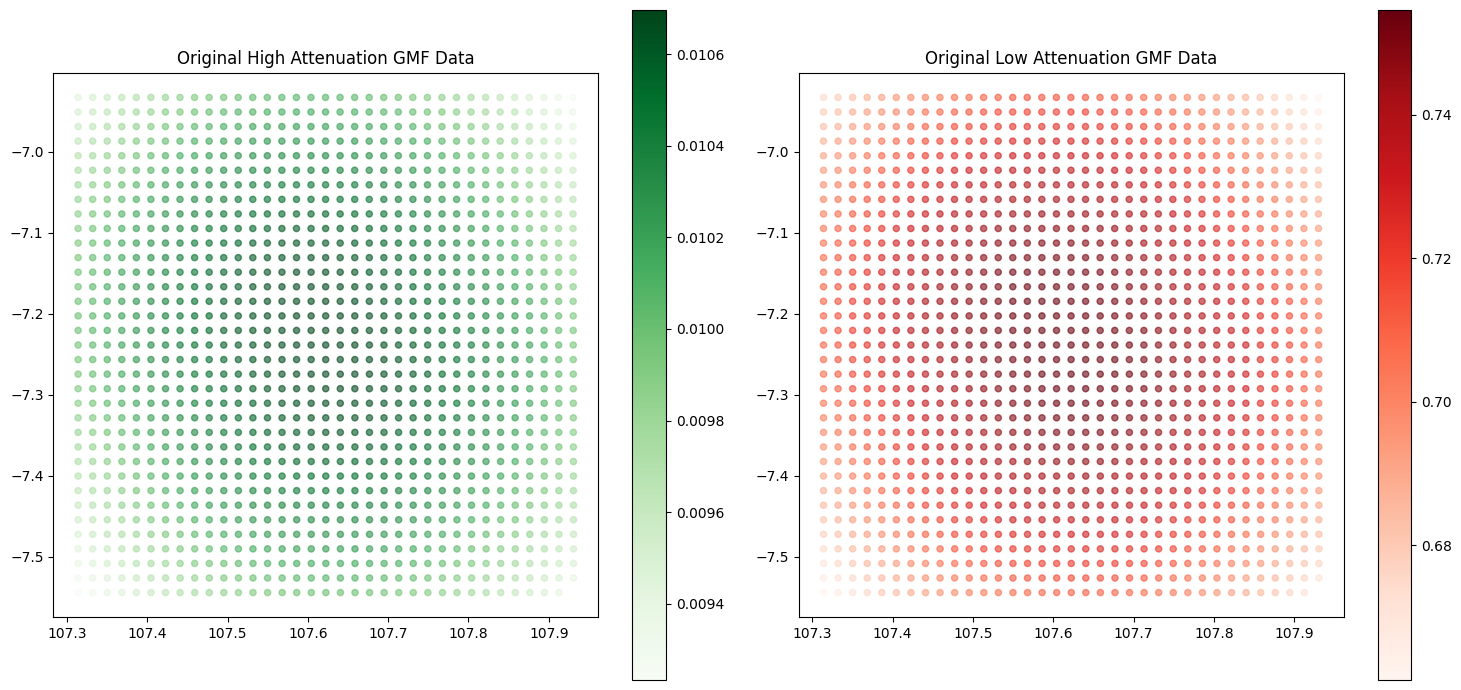

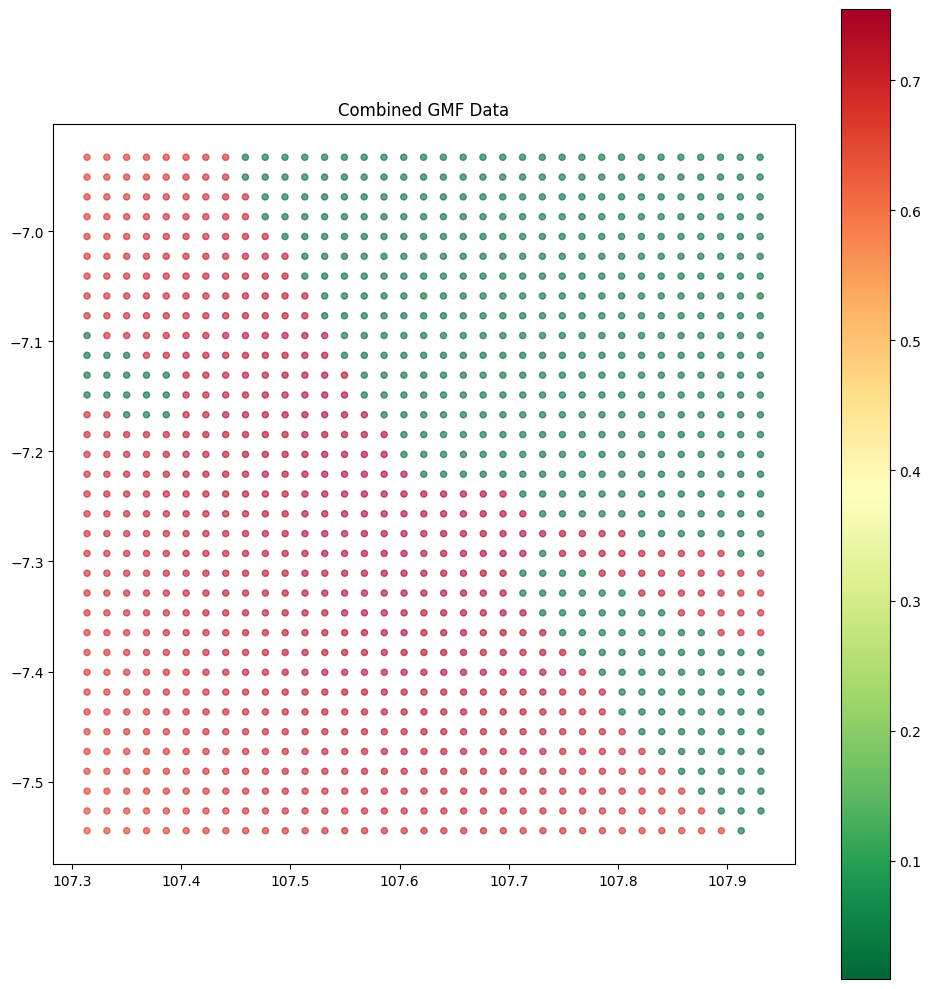

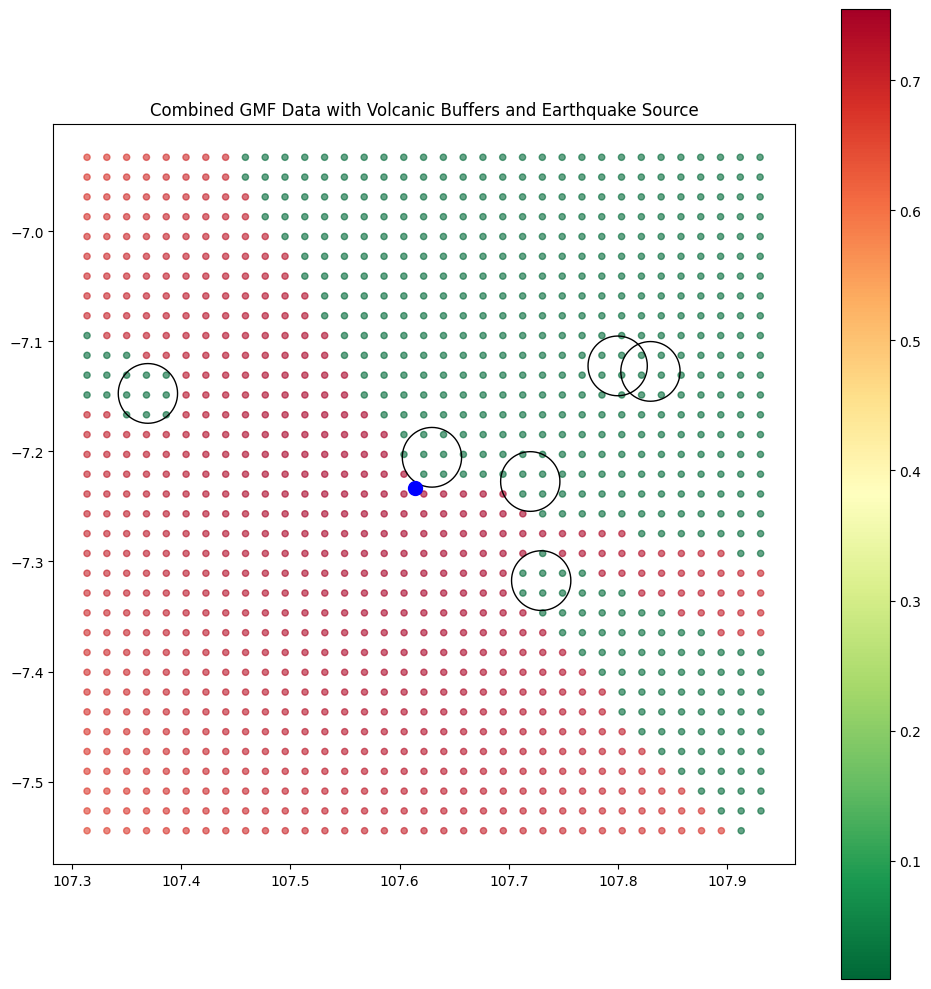

The black outline hollow circles are volcanoes 
The blue dot is the rupture source of this earthquake.
Combined GMF data saved as: assets/combined_gmf.csv


In [4]:
def save_and_visualise_combined_gmf(combined_gmf, gmf_h_gdf, gmf_l_gdf, buffer_file, output_csv_path):
    combined_gmf.to_csv(output_csv_path, index=False)
    combined_gmf_gdf = gpd.GeoDataFrame(combined_gmf, geometry=gpd.points_from_xy(combined_gmf.Longitude, combined_gmf.Latitude), crs="EPSG:4326")
 
#Test    
    assert not combined_gmf_gdf.empty, "Combined GMF GeoDataFrame should not be empty."
    assert 'geometry' in combined_gmf_gdf.columns, "Combined GMF GeoDataFrame should contain geometry column."
    assert combined_gmf_gdf.crs.to_string() == 'EPSG:4326', "Combined GMF GeoDataFrame should have EPSG:4326 CRS."
    
    # visualise original GMFs data
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    # Plot high attenuation GMF data
    gmf_h_gdf.plot(ax=ax[0], column='gmv_PGA', legend=True, cmap='Greens', markersize=20, alpha=0.6)
    ax[0].set_title('Original High Attenuation GMF Data')

    # Plot low attenuation GMF data
    gmf_l_gdf.plot(ax=ax[1], column='gmv_PGA', legend=True, cmap='Reds', markersize=20, alpha=0.6)
    ax[1].set_title('Original Low Attenuation GMF Data')

    plt.tight_layout()
    plt.show()

    # visualise combined GMF data
    fig, ax = plt.subplots(figsize=(10, 10))
    combined_gmf_gdf.plot(ax=ax, column='gmv_PGA', legend=True, cmap='RdYlGn_r', markersize=20, alpha=0.6)
    plt.title('Combined GMF Data')
    plt.tight_layout()
    plt.show()

    # visualise combined GMF data with volcanic buffers and earthquake source
    volcano_buffers = gpd.read_file(buffer_file)

    # Get the coverage area of GMF data
    bounds = combined_gmf_gdf.total_bounds
    minx, miny, maxx, maxy = bounds

    # Filter out volcanic buffers not within the coverage area
    volcano_buffers_within_bounds = volcano_buffers.cx[minx:maxx, miny:maxy]

    fig, ax = plt.subplots(figsize=(10, 10))
    combined_gmf_gdf.plot(ax=ax, column='gmv_PGA', legend=True, cmap='RdYlGn_r', markersize=20, alpha=0.6)
    volcano_buffers_within_bounds.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Volcanic Buffers')
    ax.plot(earthquake_source.x, earthquake_source.y, marker='o', color='blue', markersize=10, label='Earthquake Source')
    plt.title('Combined GMF Data with Volcanic Buffers and Earthquake Source')
    plt.tight_layout()
    plt.show()
    print("The black outline hollow circles are volcanoes \nThe blue dot is the rupture source of this earthquake.")
    
#Test
    print("Combined GMF data saved as:", output_csv_path)



save_and_visualise_combined_gmf(combined_gmf, gmf_h_gdf, gmf_l_gdf, 'assets/java_volcano_buffers.shp', 'assets/combined_gmf.csv')
